In [34]:
from typing import List
from typing import Tuple

import pandas as pd
import numpy as np

# Preprocessing package
from sklearn.model_selection import train_test_split

# Standardization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

# Non-Linear transformation
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# Normalization
from sklearn.preprocessing import Normalizer

# Standardization
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer


# Feature ranking
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Functions

In [35]:
def preprocessing_numerical_variables(
    df_train: pd.DataFrame, variables: List[str], method: str
) -> Tuple[pd.DataFrame, object]:
    """
    Performs preprocessing on numerical variables in a training DataFrame.

    Args:
        df_train (pd.DataFrame): Training DataFrame containing the variables to be preprocessed.
        variables (List[str]): List of names of the numerical variables to be preprocessed.
        method (str): Preprocessing method to be used. Currently, only "StandardScaler" is supported.

    Returns:
        Tuple[pd.DataFrame, object]: Tuple containing the DataFrame with the preprocessed numerical variables and the preprocessing method object.

    Raises:
        ValueError: If the provided preprocessing method is not supported.
    """
    df = df_train.copy()

    

    if method == "StandardScaler":
        preprocessing_method = StandardScaler()
    else:
        raise ValueError("Unsupported preprocessing method.")

    X_train = df.loc[:, variables].values
    X_train_processed = preprocessing_method.fit_transform(X_train)

    df.loc[:, variables] = X_train_processed

    return df, preprocessing_method

In [36]:
# load data
csv_link = "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
df = pd.read_csv(csv_link)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [37]:
# size dataframe
df.shape

(299, 13)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [39]:
print("No Death patients: ", df.loc[df["DEATH_EVENT"] == 0].shape[0])
print("Death patients: ", df.loc[df["DEATH_EVENT"] == 1].shape[0])

No Death patients:  203
Death patients:  96


Dataframe desbalanceado

In [40]:
import pandas as pd

# Load data
csv_link = "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
df = pd.read_csv(csv_link)

variables = ["anaemia", "high_blood_pressure", "diabetes", "sex", "smoking"]
summary_list = []

# Iterate over selected variables
for var in variables:
    # Calculate counts and percentages for the full sample
    full_sample_count = df[var].value_counts()
    full_sample_percent = df[var].value_counts(normalize=True) * 100

    # Calculate counts and percentages for patients who died
    dead_sample_count = df[df["DEATH_EVENT"] == 1][var].value_counts()
    dead_sample_percent = (
        df[df["DEATH_EVENT"] == 1][var].value_counts(normalize=True) * 100
    )

    # Calculate counts and percentages for patients who survived
    survived_sample_count = df[df["DEATH_EVENT"] == 0][var].value_counts()
    survived_sample_percent = (
        df[df["DEATH_EVENT"] == 0][var].value_counts(normalize=True) * 100
    )

    # Create temporary DataFrame for each variable and value
    for val in [0, 1]:
        temp_df = pd.DataFrame(
            {
                "Variable": var,
                "Bool": val,
                "Full Sample #": full_sample_count.get(val, 0),
                "Full Sample %": full_sample_percent.get(val, 0),
                "Dead Patients #": dead_sample_count.get(val, 0),
                "Dead Patients %": dead_sample_percent.get(val, 0),
                "Survived Patients #": survived_sample_count.get(val, 0),
                "Survived Patients %": survived_sample_percent.get(val, 0),
            },
            index=[0],
        )
        summary_list.append(temp_df)

# Concatenate all temporary DataFrames into a single summary DataFrame
summary_df = pd.concat(summary_list, ignore_index=True)
summary_df = summary_df.round(2)
summary_df

,Variable,Bool,Full Sample #,Full Sample %,Dead Patients #,Dead Patients %,Survived Patients #,Survived Patients %
0,anaemia,0,170,56.86,50,52.08,120,59.11
1,anaemia,1,129,43.14,46,47.92,83,40.89
2,high_blood_pressure,0,194,64.88,57,59.38,137,67.49
3,high_blood_pressure,1,105,35.12,39,40.62,66,32.51
4,diabetes,0,174,58.19,56,58.33,118,58.13
5,diabetes,1,125,41.81,40,41.67,85,41.87
6,sex,0,105,35.12,34,35.42,71,34.98
7,sex,1,194,64.88,62,64.58,132,65.02
8,smoking,0,203,67.89,66,68.75,137,67.49
9,smoking,1,96,32.11,30,31.25,66,32.51


# Preprocessing data

In [41]:
columns = df.columns
target = "DEATH_EVENT"
features = columns.drop(target)

# Especifique as colunas que são as variáveis independentes (X) e a variável dependente (y)
X = df.loc[:, features].copy()
y = df.loc[:, target].copy()  # substitua 'target' pelo nome da sua coluna alvo

# Divida os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# X_train: conjunto de treinamento de características (variáveis independentes)
# X_test: conjunto de teste de características (variáveis independentes)
# y_train: conjunto de treinamento do alvo (variável dependente)
# y_test: conjunto de teste do alvo (variável dependente)

# Verifique os tamanhos dos conjuntos de treinamento e teste
print("Tamanho do conjunto de treinamento:", len(X_train))
print("Tamanho do conjunto de teste:", len(X_test))

Tamanho do conjunto de treinamento: 209
Tamanho do conjunto de teste: 90


In [42]:
positive_skewness_variables = [
    "creatinine_phosphokinase",
    "platelets",
    "serum_creatinine",
]

negative_skewness_variables = ["serum_sodium"]

for positive_skewness_variable in positive_skewness_variables:
    log_str = "log_" + positive_skewness_variable

    X_train[log_str] = np.log1p(X_train[positive_skewness_variable])
    X_test[log_str] = np.log1p(X_test[positive_skewness_variable])

    X_train.drop(columns=positive_skewness_variable, inplace=True)
    X_test.drop(columns=positive_skewness_variable, inplace=True)

for negative_skewness_variable in negative_skewness_variables:
    sqrt_str = "sqrt_" + negative_skewness_variable

    X_train[sqrt_str] = np.sqrt(X_train[negative_skewness_variable])
    X_test[sqrt_str] = np.sqrt(X_test[negative_skewness_variable])

    X_train.drop(columns=negative_skewness_variable, inplace=True)
    X_test.drop(columns=negative_skewness_variable, inplace=True)


min_max_variables = ["age", "ejection_fraction", "time"]

standard_variables = [
    "log_creatinine_phosphokinase",
    "log_platelets",
    "log_serum_creatinine",
    "sqrt_serum_sodium",
]

min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

X_train[min_max_variables] = min_max_scaler.fit_transform(X_train[min_max_variables])
X_test[min_max_variables] = min_max_scaler.transform(X_test[min_max_variables])

X_train[standard_variables] = standard_scaler.fit_transform(X_train[standard_variables])
X_test[standard_variables] = standard_scaler.transform(X_test[standard_variables])

# Feature Ranking

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Remover a coluna "time" do conjunto de treinamento
X_train_model = X_train.drop(columns="time")

# Definir os hiperparâmetros a serem testados
param_grid = {
    "n_estimators": [100, 200, 300],  # número de árvores na floresta
    "max_depth": [None, 5, 10],  # profundidade máxima das árvores
    "min_samples_split": [2, 5, 10],  # número mínimo de amostras necessárias para split
    "min_samples_leaf": [1, 2, 4],  # número mínimo de amostras em cada folha
}

# Criar o classificador Random Forest
model = RandomForestClassifier()

# Criar o objeto GridSearchCV para busca em grade com validação cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Executar a busca em grade para encontrar os melhores hiperparâmetros
grid_search.fit(X_train_model, y_train)

# Exibir os melhores hiperparâmetros encontrados
best_params = grid_search.best_params_
print("Melhores hiperparâmetros encontrados:")
print(best_params)

RandomForestClassifier()

predict survival and to perform the feature ranking as a function of the follow-up time

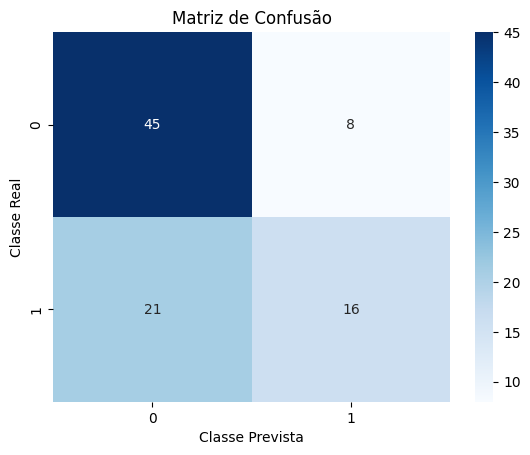

              precision    recall  f1-score   support

           0       0.68      0.85      0.76        53
           1       0.67      0.43      0.52        37

    accuracy                           0.68        90
   macro avg       0.67      0.64      0.64        90
weighted avg       0.68      0.68      0.66        90



In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Remover a coluna "time" do conjunto de teste
X_test_model = X_test.drop(columns="time")

# Fazer previsões no conjunto de teste
y_pred = grid_search.predict(X_test_model)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão em forma de heatmap
sns.heatmap(conf_matrix, annot=True, cmap="Blues")
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")
plt.title("Matriz de Confusão")
plt.show()

# Exibir o relatório de classificação
report = classification_report(y_test, y_pred)
print(report)